# models for opcode frequency

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split

2025-07-12 00:39:16.561107: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Const

In [2]:
PATH = Path.cwd().parents[1]
DATA_PATH = os.path.join(PATH, 'data/processed')
MODEL_PATH = os.path.join(PATH, 'models')

In [3]:
with open(os.path.join(DATA_PATH, 'feature-opcode-freq_list.json')) as f:
    feature_list = json.load(f)

with open(os.path.join(DATA_PATH, 'labels-opcode-freq.json')) as f:
    labels = json.load(f)

In [4]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train-opcode-freq.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test-opcode-freq.csv'))

X_train = train_df[feature_list]
y_train = train_df[labels]

X_test = test_df[feature_list]
y_test = test_df[labels]

opcode_dim = len(feature_list)

## CNN With Autoencoder

In [5]:
X_unlabeled = np.concatenate([X_train, X_test], axis=0)
# Input
input_layer = Input(shape=(opcode_dim,))

# Encoder
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)

# Decoder
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(opcode_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_unlabeled, X_unlabeled, epochs=30, batch_size=64)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7238.4917
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7245.3921
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7141.9976
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6896.3647
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7133.2246
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7400.4893
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7267.5000
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7027.7852
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7194.5459
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7046.4658
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6925.0244
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7135.4590
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7037.8848
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7078.7217
Epoch 15/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss:

In [6]:
X_encoded = encoder.predict(X_train)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y_train, test_size=0.2, random_state=42)

In [15]:
def EncodedMLClassifier():
    return Sequential([
        Dense(256, input_dim=128, kernel_regularizer=regularizers.L1L2(1e-6)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.L1L2(1e-6)),
        BatchNormalization(),
        LeakyReLU(alpha=1e-6),
        Dropout(0.2),

        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),

        Dense(len(labels), activation='sigmoid')
    ])

classifier = EncodedMLClassifier()

classifier.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

model_file = os.path.join(MODEL_PATH, "encoded_cnn_best_model_on_crpwarner_opcode_freq.h5")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(model_file, save_best_only=True)
]

history = classifier.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4688 - loss: 0.6994

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 424ms/step - accuracy: 0.4376 - loss: 0.7030 - val_accuracy: 0.3571 - val_loss: 3.3938 - learning_rate: 0.0010
Epoch 2/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6094 - loss: 0.5550

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5762 - loss: 0.5763 - val_accuracy: 0.3571 - val_loss: 3.2418 - learning_rate: 0.0010
Epoch 3/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6250 - loss: 0.5129

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6365 - loss: 0.5118 - val_accuracy: 0.3571 - val_loss: 2.9030 - learning_rate: 0.0010
Epoch 4/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5781 - loss: 0.5646

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5964 - loss: 0.5455 - val_accuracy: 0.3571 - val_loss: 2.4042 - learning_rate: 0.0010
Epoch 5/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6719 - loss: 0.4835

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6643 - loss: 0.4915 - val_accuracy: 0.3571 - val_loss: 2.0476 - learning_rate: 0.0010
Epoch 6/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7188 - loss: 0.4574

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7166 - loss: 0.4623 - val_accuracy: 0.3571 - val_loss: 1.7902 - learning_rate: 0.0010
Epoch 7/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6719 - loss: 0.4664

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6888 - loss: 0.4508 - val_accuracy: 0.3571 - val_loss: 1.6492 - learning_rate: 0.0010
Epoch 8/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6875 - loss: 0.4173

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6818 - loss: 0.4292 - val_accuracy: 0.3571 - val_loss: 1.6054 - learning_rate: 0.0010
Epoch 9/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7344 - loss: 0.4146

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7219 - loss: 0.4197 - val_accuracy: 0.3571 - val_loss: 1.5805 - learning_rate: 0.0010
Epoch 10/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7969 - loss: 0.3715

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7733 - loss: 0.3832 - val_accuracy: 0.3571 - val_loss: 1.4673 - learning_rate: 0.0010
Epoch 11/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7188 - loss: 0.4360

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7350 - loss: 0.4147 - val_accuracy: 0.3571 - val_loss: 1.3607 - learning_rate: 0.0010
Epoch 12/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6719 - loss: 0.3677

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6888 - loss: 0.3720 - val_accuracy: 0.3571 - val_loss: 1.2438 - learning_rate: 0.0010
Epoch 13/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7344 - loss: 0.3730

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7280 - loss: 0.3777 - val_accuracy: 0.3571 - val_loss: 1.0998 - learning_rate: 0.0010
Epoch 14/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7344 - loss: 0.3584

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7402 - loss: 0.3722 - val_accuracy: 0.3571 - val_loss: 0.9661 - learning_rate: 0.0010
Epoch 15/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6719 - loss: 0.3480

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7071 - loss: 0.3581 - val_accuracy: 0.4286 - val_loss: 0.8539 - learning_rate: 0.0010
Epoch 16/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6875 - loss: 0.3631

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6818 - loss: 0.3613 - val_accuracy: 0.4286 - val_loss: 0.7997 - learning_rate: 0.0010
Epoch 17/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7656 - loss: 0.3681

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7384 - loss: 0.3607 - val_accuracy: 0.4643 - val_loss: 0.7942 - learning_rate: 0.0010
Epoch 18/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6775 - loss: 0.3561 - val_accuracy: 0.5000 - val_loss: 0.8093 - learning_rate: 0.0010
Epoch 19/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7436 - loss: 0.3206 - val_accuracy: 0.5000 - val_loss: 0.8111 - learning_rate: 0.0010
Epoch 20/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7500 - loss: 0.3150
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7393 - loss: 0.3041 - val_accuracy: 0.5000 - val_loss: 0.8139 - learning_rate: 0.0010
Epoch 21/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7969 - loss: 0.3301

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7794 - loss: 0.3200 - val_accuracy: 0.5000 - val_loss: 0.7668 - learning_rate: 5.0000e-04
Epoch 22/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7344 - loss: 0.2796

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7586 - loss: 0.2932 - val_accuracy: 0.5000 - val_loss: 0.7046 - learning_rate: 5.0000e-04
Epoch 23/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7656 - loss: 0.3330

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7812 - loss: 0.3269 - val_accuracy: 0.5000 - val_loss: 0.6781 - learning_rate: 5.0000e-04
Epoch 24/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7812 - loss: 0.2667

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7619 - loss: 0.2794 - val_accuracy: 0.5000 - val_loss: 0.6704 - learning_rate: 5.0000e-04
Epoch 25/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7188 - loss: 0.2991

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7350 - loss: 0.2872 - val_accuracy: 0.5000 - val_loss: 0.6581 - learning_rate: 5.0000e-04
Epoch 26/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8125 - loss: 0.2911

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7968 - loss: 0.2896 - val_accuracy: 0.5357 - val_loss: 0.6541 - learning_rate: 5.0000e-04
Epoch 27/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8594 - loss: 0.2685

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8369 - loss: 0.2768 - val_accuracy: 0.5357 - val_loss: 0.6337 - learning_rate: 5.0000e-04
Epoch 28/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8125 - loss: 0.2546

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7846 - loss: 0.2629 - val_accuracy: 0.5714 - val_loss: 0.6301 - learning_rate: 5.0000e-04
Epoch 29/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7656 - loss: 0.3304

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7873 - loss: 0.3126 - val_accuracy: 0.5714 - val_loss: 0.6220 - learning_rate: 5.0000e-04
Epoch 30/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7969 - loss: 0.2678

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8100 - loss: 0.2727 - val_accuracy: 0.5714 - val_loss: 0.6103 - learning_rate: 5.0000e-04
Epoch 31/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7812 - loss: 0.2836

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7803 - loss: 0.2628 - val_accuracy: 0.6429 - val_loss: 0.5902 - learning_rate: 5.0000e-04
Epoch 32/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7812 - loss: 0.2826

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7742 - loss: 0.2606 - val_accuracy: 0.6429 - val_loss: 0.5780 - learning_rate: 5.0000e-04
Epoch 33/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8906 - loss: 0.2310

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8473 - loss: 0.2517 - val_accuracy: 0.6429 - val_loss: 0.5656 - learning_rate: 5.0000e-04
Epoch 34/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7344 - loss: 0.2858

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7647 - loss: 0.2777 - val_accuracy: 0.6429 - val_loss: 0.5373 - learning_rate: 5.0000e-04
Epoch 35/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7500 - loss: 0.2574

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7821 - loss: 0.2585 - val_accuracy: 0.6786 - val_loss: 0.5139 - learning_rate: 5.0000e-04
Epoch 36/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7864 - loss: 0.2653 - val_accuracy: 0.6786 - val_loss: 0.5147 - learning_rate: 5.0000e-04
Epoch 37/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7925 - loss: 0.2493 - val_accuracy: 0.6786 - val_loss: 0.5168 - learning_rate: 5.0000e-04
Epoch 38/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7812 - loss: 0.2598

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7681 - loss: 0.2511 - val_accuracy: 0.7143 - val_loss: 0.5100 - learning_rate: 5.0000e-04
Epoch 39/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8594 - loss: 0.2336

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8247 - loss: 0.2380 - val_accuracy: 0.7857 - val_loss: 0.4963 - learning_rate: 5.0000e-04
Epoch 40/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7812 - loss: 0.2585

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7803 - loss: 0.2533 - val_accuracy: 0.7500 - val_loss: 0.4753 - learning_rate: 5.0000e-04
Epoch 41/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7344 - loss: 0.2937

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7647 - loss: 0.2818 - val_accuracy: 0.7143 - val_loss: 0.4620 - learning_rate: 5.0000e-04
Epoch 42/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7656 - loss: 0.2476

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7934 - loss: 0.2415 - val_accuracy: 0.7143 - val_loss: 0.4477 - learning_rate: 5.0000e-04
Epoch 43/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8274 - loss: 0.2342 - val_accuracy: 0.7143 - val_loss: 0.4568 - learning_rate: 5.0000e-04
Epoch 44/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7968 - loss: 0.2453 - val_accuracy: 0.7143 - val_loss: 0.4763 - learning_rate: 5.0000e-04
Epoch 45/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7656 - loss: 0.2648
Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7934 - loss: 0.2475 - val_accuracy: 0.7500 - val_loss: 0.5005 - learning_rate: 5.0000e-04
Epoch 46/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7803 - loss: 0.2318 - val_accuracy: 0.7500 - val_loss: 0.5029 - learning_rate: 2.5000e-04
Epoch 47/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8204 - loss: 0.2246 - v

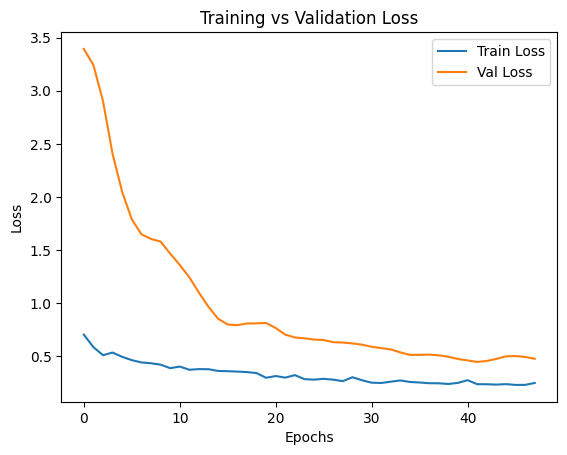

In [16]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [17]:
y_pred_prob = classifier.predict(X_val)
y_pred = (y_pred_prob >= 0.05).astype(int)

print(classification_report(y_val, y_pred, target_names=labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
              precision    recall  f1-score   support

        mint       0.29      1.00      0.44         6
        leak       0.43      1.00      0.61        10
       limit       0.41      1.00      0.58         7

   micro avg       0.38      1.00      0.55        23
   macro avg       0.38      1.00      0.54        23
weighted avg       0.39      1.00      0.56        23
 samples avg       0.44      0.79      0.54        23



/usr/local/anaconda3/envs/ml-algo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
